In [2]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sts
import statsmodels.stats.weightstats as wsts

from sklearn import model_selection, linear_model, ensemble, metrics

import matplotlib.pyplot as plt

/Users/artem/miniconda3/envs/mldaspec/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/artem/miniconda3/envs/mldaspec/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


___
Уровень кальция в крови здоровых молодых женщин равен в среднем 9.5 милиграммам на децилитр и имеет характерное стандартное отклонение 0.4 мг/дл. В сельской больнице Гватемалы для 160 здоровых беременных женщин при первом обращении для ведения беременности был измерен уровень кальция; среднее значение составило 9.57 мг/дл. Можно ли утверждать, что средний уровень кальция в этой популяции отличается от 9.5?

Посчитайте достигаемый уровень значимости. Поскольку известны только среднее и дисперсия, а не сама выборка, нельзя использовать стандартные функции критериев — нужно реализовать формулу достигаемого уровня значимости самостоятельно.

Округлите ответ до четырёх знаков после десятичной точки.

In [3]:
mu0 = 9.5
std0 = 0.4
X = 9.57
n = 160
z = (X - mu0) / (std0 / np.sqrt(n))

In [4]:
norm = scipy.stats.norm()

In [5]:
2 * (1 - norm.cdf(np.abs(z)))

0.026856695507523787

In [7]:
wsts._zconfint_generic(X, std0 / np.sqrt(n), 0.05, 'two-sided')

(9.508020496769545, 9.631979503230456)

In [8]:
wsts._zconfint_generic(mu0, std0, 0.05, 'two-sided')

(8.716014406183978, 10.283985593816022)

___
Имеются данные о стоимости и размерах 53940 бриллиантов:

In [9]:
df = pd.read_csv('data/diamonds.txt', sep='\t')
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


Отделите 25% случайных наблюдений в тестовую выборку с помощью функции sklearn.cross_validation.train_test_split (зафиксируйте random state = 1). На обучающей выборке настройте две регрессионные модели:

 - линейную регрессию с помощью LinearRegression без параметров
 - случайный лес с помощью RandomForestRegressor с random_state=1.
Какая из моделей лучше предсказывает цену бриллиантов? 

Сделайте предсказания на тестовой выборке, посчитайте модули отклонений предсказаний от истинных цен. Проверьте гипотезу об одинаковом среднем качестве предсказаний, вычислите достигаемый уровень значимости. 

**Отвергается ли гипотеза об одинаковом качестве моделей против двусторонней альтернативы на уровне значимости 
α=0.05?**

In [10]:
X = df.drop('price', axis=1)  # .values
y = df['price']

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1)

In [12]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
diffs_linregr = np.abs(lin_regr.predict(X_test) - y_test)

In [14]:
rf_regr = ensemble.RandomForestRegressor(random_state=1)
rf_regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [15]:
diffs_rfregr = np.abs(rf_regr.predict(X_test) - y_test)

Hypothesis:  
$H_0: \mu_1 = \mu_2$  
$H_1: \mu_1 \ne \mu_2$

In [23]:
metrics.mean_absolute_error(y_test, lin_regr.predict(X_test))

890.3764004285604

In [26]:
metrics.mean_absolute_error(y_test, rf_regr.predict(X_test))

803.6143383081302

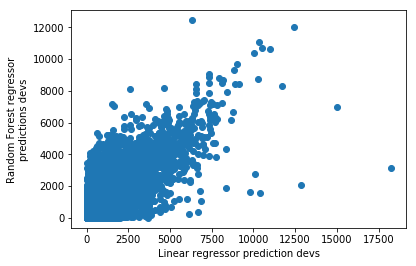

In [16]:
plt.scatter(diffs_linregr, diffs_rfregr)
plt.xlabel('Linear regressor prediction devs')
plt.ylabel('Random Forest regressor\npredictions devs');

$H_0:$ распределение попарных разностей существенно не отличается от нормального  
$H_1:$ отличается существенно

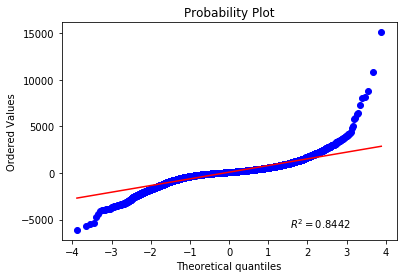

In [17]:
sts.probplot(diffs_linregr - diffs_rfregr, dist='norm', rvalue=True, plot=plt);

In [18]:
# For a huge samples chance to reject the H_0 is extremely small
sts.shapiro(diffs_linregr - diffs_rfregr)

/Users/artem/miniconda3/envs/mldaspec/lib/python3.7/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.845048725605011, 0.0)

Проверяем гипотезы по критерию Стьюдента для связанных выборок, т.к. предполагаем по Q-Q графику что отклонения несущественны. А также мы обучались на одной и той же выборке в обоих случаях.  
$H_0: \mu_{linregr~devs} = \mu_{rfregr~devs}$  
$H_1: \mu_{linregr~devs} \ne \mu_{rfregr~devs}$

In [19]:
sts.ttest_rel(diffs_linregr, diffs_rfregr)

Ttest_relResult(statistic=12.930817614948769, pvalue=5.074175575660666e-38)

In [20]:
cm = wsts.CompareMeans(wsts.DescrStatsW(diffs_linregr), wsts.DescrStatsW(diffs_rfregr))
print(cm.tconfint_diff(usevar='unequal'))

(59.12439535320714, 114.399728887653)


In [21]:
(diffs_linregr - diffs_rfregr).mean()

86.76206212043

In [22]:
wsts.zconfint(diffs_linregr - diffs_rfregr)

(73.61126825385489, 99.91285598700512)